In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import pandas as pd
import numpy as np
from forecast.metrics import crps, calculate_crps_scores
# plot CRPS scores for each horizon
import matplotlib.pyplot as plt

In [17]:
reals = pd.read_csv('debug_logs/real_power_point_and_variance_9000_gmm_14march_1.csv')
reals = reals.iloc[1:, :]
reals = reals.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
reals = reals.sort_values(by=['time_step', 'building'])
reals['building'] = reals['building'].str[-1].astype(int)
reals = reals[reals['time_step'] != -1]
lead_times = ['net_target+'+str(i) for i in range(2, 25)]
reals_h24 = pd.DataFrame()
for building in range(5):
    reals_h24_temp = pd.DataFrame()
    reals_h24_temp['time_step'] = reals.loc[reals['building'] == building, 'time_step']
    reals_h24_temp['building'] = building
    reals_h24_temp['net_target+1'] = reals.loc[reals['building'] == building, 'net_target']
    for i, lead_time in enumerate(lead_times):
        reals_h24_temp[lead_time] = reals_h24_temp['net_target+1'].shift(-int(i+1))
    reals_h24 = pd.concat([reals_h24, reals_h24_temp], axis=0)
reals_h24 = reals_h24.dropna()
# reals time_step as int
reals_h24 = reals_h24.sort_values(by=['time_step', 'building'])
# set the index to time_step and building
reals_h24 = reals_h24.set_index(['time_step', 'building'], drop=False)
reals_h24

time_step  building  net_target+1  net_target+2  \
time_step building                                                    
0         0                 0         0  8.511667e-01  8.346000e-01   
          1                 0         1  1.370667e+00  1.101250e+00   
          2                 0         2  1.018524e-07  1.008352e-07   
          3                 0         3  1.928167e+00  4.758167e-01   
          4                 0         4  5.158833e-01  5.030500e-01   
...                       ...       ...           ...           ...   
8735      0              8735         0  1.581708e+00  5.796833e-01   
          1              8735         1  2.289758e+00  5.151167e-01   
          2              8735         2  7.067500e-01  4.349000e-01   
          3              8735         3  3.510683e+00  2.099967e+00   
          4              8735         4  1.343600e+00  9.951167e-01   

                    net_target+3  net_target+4  net_target+5  net_target+6  \
time_step building                                                           
0         0         8.381667e-01  1.478433e+00  1.256200e+00      1.811500   
          1         5.432167e-01  5.428333e-01  1.512433e+00      0.326250   
          2         1.007080e-07  1.015981e-07  9.943644e-08     -0.027283   
          3         4.582333e-01  4.460167e-01  4.658833e-01      0.637133   
          4         5.359500e-01  5.126167e-01  3.032167e-01      0.378583   
...                          ...           ...           ...           ...   
8735      0         5.926500e-01  5.763333e-01  5.861833e-01      0.590600   
          1         7.532500e-01  7.767167e-01  1.895200e+00      0.350383   
          2         4.231333e-01  4.464667e-01  3.864667e-01      0.377350   
          3         2.567050e+00  5.842667e-01  7.306833e-01      1.942067   
          4         9.510333e-01  6.088167e-01  5.943000e-01      0.376467   

                    net_target+7  net_target+8  ...  net_target+15  \
time_step building                              ...                  
0         0             0.362733     -0.489917  ...      -0.595117   
          1             0.560617      1.119483  ...       0.935333   
          2            -0.136700     -0.034533  ...      -1.413883   
          3             0.698950      2.152567  ...      -1.972850   
          4             0.274750     -0.070083  ...      -0.109050   
...                          ...           ...  ...            ...   
8735      0             0.770317      0.220983  ...      -0.199817   
          1             0.319250      0.222683  ...       0.944117   
          2             0.314100      0.235600  ...      -1.414011   
          3             0.466517      0.851900  ...       0.192433   
          4             0.444233     -0.149983  ...       0.522200   

                    net_target+16  net_target+17  net_target+18  \
time_step building                                                
0         0             -0.298267       0.059700       1.054850   
          1              0.204017      -0.572450      -0.678733   
          2             -1.743550      -1.656633      -0.879733   
          3             -2.074017      -0.055433       0.160417   
          4             -0.137150       0.023717       2.313683   
...                           ...            ...            ...   
8735      0              0.115850       0.803650       2.636517   
          1              1.083967      -1.310933      -1.106450   
          2             -0.635250      -0.525617       0.284317   
          3             -0.329417       0.222217       1.017867   
          4              1.169617       1.663533       3.119600   

                    net_target+19  net_target+20  net_target+21  \
time_step building                                                
0         0              1.006983   3.603983e+00   5.008500e+00   
          1             -0.069417   3.583334e-01   1.584500e+00   
          2             -0.045

In [18]:
# open csv file for scenarios
scens = pd.read_csv('debug_logs/scenarios_point_and_variance_9000_1_gmm_16march.csv')
# remove rows with time_step 8759
scens = scens[scens['time_step'] != 8759]
scens_pv = pd.read_csv('debug_logs/scenarios_point_and_variance_9000_1_norm_16march.csv')
scens_pv = scens_pv[scens_pv['time_step'] != 8759]
scens_covariance = pd.read_csv('debug_logs/scenarios_full_covariance_9000_1_0means_15march.csv')
scens_covariance = scens_covariance[scens_covariance['time_step'] != 8759]
scens_point = pd.read_csv('debug_logs/scenarios_point_recurrent_9000_1.csv')
scens_point = scens_point[scens_point['time_step'] != 8759]
# set time_step and building as index
scens = scens.set_index(['time_step', 'building'], drop=False)
scens_pv = scens_pv.set_index(['time_step', 'building'], drop=False)
scens_covariance = scens_covariance.set_index(['time_step', 'building'], drop=False)
scens_point = scens_point.set_index(['time_step', 'building'], drop=False)
# keep only indexes that are in reals
scens = scens.loc[reals_h24.index]
scens_pv = scens_pv.loc[reals_h24.index]
scens_covariance = scens_covariance.loc[reals_h24.index]
scens_point = scens_point.loc[reals_h24.index]
scens

time_step  scenario  building       +1h       +2h  \
time_step building                                                      
0         0                 0         0         0  0.140059 -0.124326   
          0                 0         1         0 -0.864255 -0.061880   
          0                 0         2         0  1.960202 -0.211055   
          0                 0         3         0  0.438457 -0.027377   
          0                 0         4         0  0.393208 -0.117976   
...                       ...       ...       ...       ...       ...   
8735      4              8735         5         4  0.918262  0.551245   
          4              8735         6         4  0.748144  0.511732   
          4              8735         7         4  1.015560  0.674388   
          4              8735         8         4  0.876956  0.630571   
          4              8735         9         4  1.010573  0.567866   

                         +3h       +4h       +5h       +6h       +7h  ...  \
time_step building                                                    ...   
0         0        -0.125364 -0.042354  0.625479 -0.103677 -0.411441  ...   
          0        -0.177586 -0.034099  0.539442 -0.092871 -0.644062  ...   
          0        -0.129122  0.036903 -0.940767 -0.073213 -1.325969  ...   
          0        -0.146201 -0.042786  0.153931  0.110595 -0.379771  ...   
          0        -0.075127 -0.064262  0.210966  0.211978 -0.505198  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      4         0.454786  0.548646  0.866407  0.337952  0.117532  ...   
          4         0.893644  0.509534  1.176059  0.337000  0.426546  ...   
          4         1.677950  0.509671  0.927553  0.409090 -0.062337  ...   
          4        -0.673758  0.504391  0.058974  0.393878  0.588093  ...   
          4         1.013132  0.340167  0.659471  0.459328 -0.604583  ...   

                        +15h      +16h      +17h      +18h      +19h  \
time_step building                                                     
0         0        -2.400861 -1.894240 -1.886869 -1.354229 -0.943725   
          0        -2.343349 -1.689445 -1.263713 -1.422169  0.165045   
          0        -2.395684 -1.922793 -1.107194 -1.578695  4.030196   
          0        -2.458008 -2.317250 -1.538089 -1.032365 -0.304778   
          0        -2.315825 -0.717816 -1.256110 -1.411999  0.324366   
...                      ...       ...       ...       ...       ...   
8735      4        -0.167575 -0.075230  1.356990  0.657076  1.443460   
          4        -0.484886 -0.112483  1.341492  0.779533  1.899990   
          4        -0.536141 -0.738029  0.610745  1.179210  1.357633   
          4         0.214270  2.212881  1.904969  1.209357  1.415097   
          4        -0.484410 -0.363116  1.498072  1.170437  1.716326   

                        +20h      +21h      +22h      +23h      +24h  
time_step building                                                    
0         0        -1.062039  1.621936  0.222736  1.195529  1.901778  
          0        -1.510588 -0.652317  0.159560  2.058082  0.358339  
          0        -0.311838 -1.630611 -0.217298  0.019281  0.097362  
          0         0.115204 -0.861151  0.055772  0.327293 -0.555807  
          0         1.488256 -0.157816 -0.585500  0.343759 -0.081482  
...                      ...       ...       ...       ...       ...  
8735      4         1.497579  1.064045  2.514479  1.783687  1.152198  
          4         1.422389  0.646288  1.047061  1.112144  1.012090  
          4         1.355254  1.126741  1.117316  0.683879  1.213553  
          4         1.315590  0.898048  1.166391  1.691390  0.854079  
          4         1.704741  0.679730  1.149614  1.685187  1.074439  

[436800 rows x 27 columns]

In [20]:
def calculate_crps_scores(reals, scens):
    crps_scores = []
    abs_scores = []
    spread_scores = []
    for i in range(1, 25):
        crps_scores_B = []
        abs_scores_B = []
        spread_scores_B = []
        for build in range(5):
            obs_input = reals.loc[reals['building'] == build, ['net_target+' + str(i)]]
            scens_input = scens.loc[scens['building'] == build, ['scenario','+' + str(i) + 'h', 'time_step']]
            scens_input = scens_input.pivot(index='time_step',columns='scenario',  values='+' + str(i) + 'h')
            obs_input = obs_input.to_numpy()
            scens_input = scens_input.to_numpy()
            abs_diff, spread, score_B = crps(obs_input, scens_input)
            abs_scores_B.append(abs_diff)
            spread_scores_B.append(spread)
            crps_scores_B.append(score_B)
            #print('CRPS score for building ' + str(build) + ' and horizon ' + str(i) + ' is ' + str(np.mean(crps_scores_B)))
        abs_scores.append(np.mean(abs_scores_B))
        spread_scores.append(np.mean(spread_scores_B))
        crps_scores.append(np.mean(crps_scores_B))
    return crps_scores, abs_scores, spread_scores

In [19]:
pv_gmm_crps_scores, pv_gmm_abs_scores, pv_gmm_spread_scores = calculate_crps_scores(reals_h24, scens)

CRPS score for building 0 and horizon 1 is 0.39478747413588494
CRPS score for building 1 and horizon 1 is 0.36178537457230064
CRPS score for building 2 and horizon 1 is 0.32725283448444054
CRPS score for building 3 and horizon 1 is 0.32008379899908673
CRPS score for building 4 and horizon 1 is 0.3056408103202617
CRPS score for building 0 and horizon 2 is 0.5002903409945685
CRPS score for building 1 and horizon 2 is 0.44878697692712144
CRPS score for building 2 and horizon 2 is 0.40569519388949243
CRPS score for building 3 and horizon 2 is 0.3952064882501557
CRPS score for building 4 and horizon 2 is 0.37905943547630994
CRPS score for building 0 and horizon 3 is 0.5380597754595104
CRPS score for building 1 and horizon 3 is 0.48600298056383484
CRPS score for building 2 and horizon 3 is 0.44133556890732617
CRPS score for building 3 and horizon 3 is 0.42924380682177926
CRPS score for building 4 and horizon 3 is 0.41211868561432696
CRPS score for building 0 and horizon 4 is 0.55354731082301

In [22]:
pv_norm_crps_scores, pv_norm_abs_scores, pv_norm_spread_scores = calculate_crps_scores(reals_h24, scens_pv)

In [23]:
crps_scores_cov, abs_scores_cov, spread_scores_cov = calculate_crps_scores(reals_h24, scens_covariance)


In [24]:
crps_point, abs_point, spread_point = calculate_crps_scores(reals_h24, scens_point)

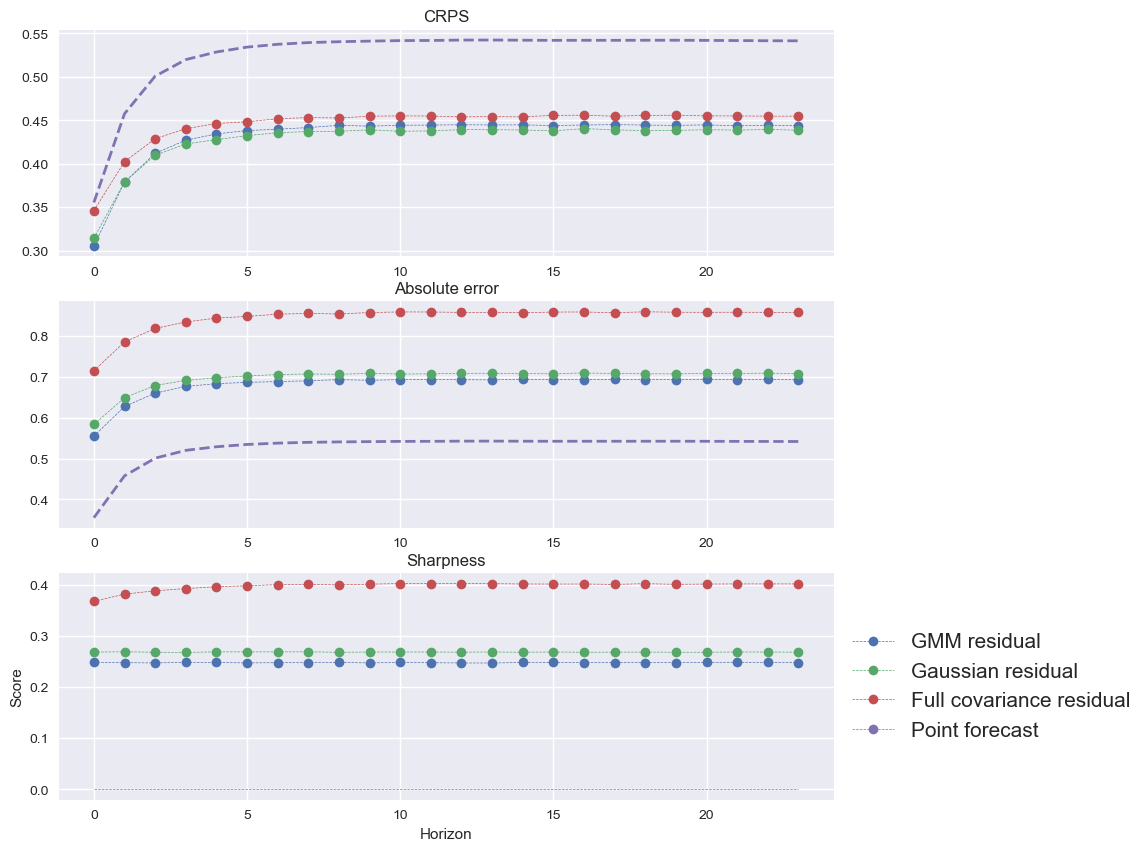

In [34]:
# make a plot with 3 subplots for each metric
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(pv_gmm_crps_scores, marker='o', linestyle='--', linewidth=0.5, label='Point and variance gmm')
axs[0].plot(pv_norm_crps_scores, marker='o', linestyle='--', linewidth=0.5, label='Point and variance gaussian')
axs[0].plot(crps_scores_cov, marker='o', linestyle='--', linewidth=0.5, label='Full covariance')
axs[0].plot(crps_point, linestyle='--', linewidth=2, label='Point forecast')
axs[0].set_title('CRPS')
axs[1].plot(pv_gmm_abs_scores, marker='o', linestyle='--', linewidth=0.5, label='Point and variance gmm')
axs[1].plot(pv_norm_abs_scores, marker='o', linestyle='--', linewidth=0.5, label='Point and variance gaussian')
axs[1].plot(abs_scores_cov, marker='o', linestyle='--', linewidth=0.5, label='Full covariance')
axs[1].plot(abs_point,  linestyle='--', linewidth=2, label='Point forecast')
axs[1].set_title('Absolute error')
axs[2].plot(pv_gmm_spread_scores, marker='o', linestyle='--', linewidth=0.5, label='Point and variance gmm')
axs[2].plot(pv_norm_spread_scores, marker='o', linestyle='--', linewidth=0.5, label='Point and variance gaussian')
axs[2].plot(spread_scores_cov, marker='o', linestyle='--', linewidth=0.5, label='Full covariance')
axs[2].plot(spread_point, linestyle='--', linewidth=0.5, label='Point forecast')
axs[2].set_title('Sharpness')

# style
plt.style.use('seaborn')

# labels
plt.xlabel('Horizon')
plt.ylabel('Score')

#plt.legend()

# legend
handles = [plt.plot([], [], color='C{}'.format(i), marker='o', linestyle='--', linewidth=0.5)[0] for i in range(4)]
labels = ['GMM residual', 'Gaussian residual', 'Full covariance residual', 'Point forecast']
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
# bigger legend

plt.show()

In [27]:
# find mean of crps scores
print('Mean of CRPS scores for point and variance gmm: {}'.format(np.mean(pv_gmm_crps_scores)))
print('Mean of CRPS scores for point and variance gaussian: {}'.format(np.mean(pv_norm_crps_scores)))
print('Mean of CRPS scores for full covariance: {}'.format(np.mean(crps_scores_cov)))
print('Mean of CRPS scores for point forecast: {}'.format(np.mean(crps_point)))

Mean of CRPS scores for point and variance gmm: 0.43292356099760704
Mean of CRPS scores for point and variance gaussian: 0.42837060308084035
Mean of CRPS scores for full covariance: 0.44571881992868617
Mean of CRPS scores for point forecast: 0.5268782143907694


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_46183/2046731440.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x[1:-1] for x in temp_scens_pv.index])


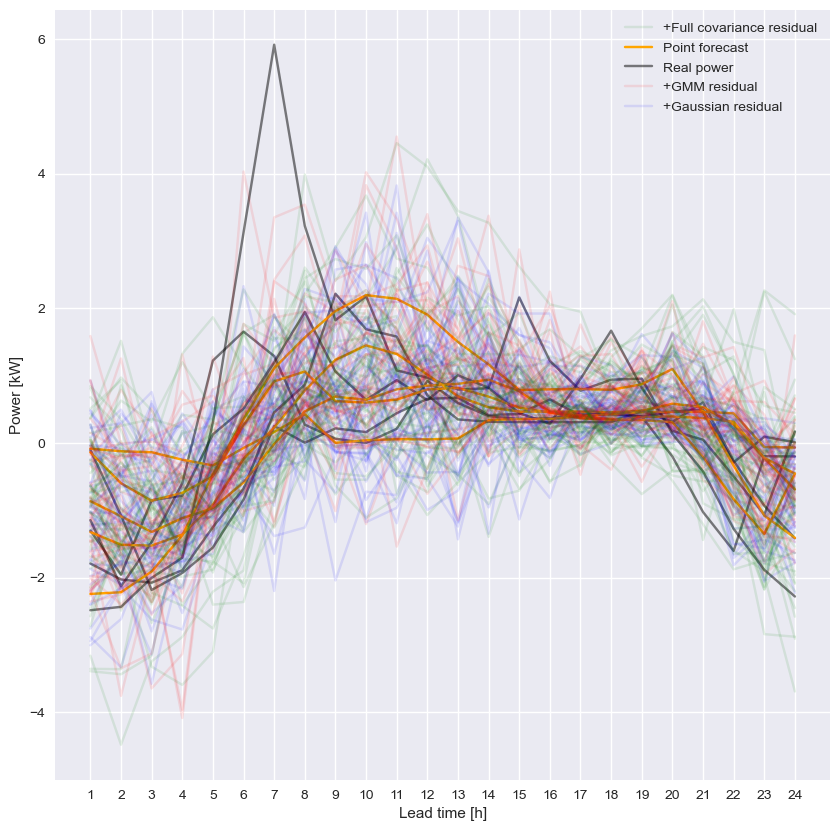

(-5.001095838650162, 6.434569643110328)


In [84]:
time_step = 1090
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

temp = reals.loc[(reals['time_step'] > time_step) & (reals['time_step'] < (time_step+25))].iloc[:, 1:]
# make index same as in scens_pv.iloc[:, 3:].T
temp.index = scens_pv.iloc[:, 3:].T.index
ax.plot(temp, color='black', alpha=0.5, label='Real power')
ax.plot(scens_point.loc[scens_point['time_step'] == time_step].iloc[:, 3:].T, color='orange', alpha=1, label='Point forecast')
ax.plot(scens_pv.loc[scens_pv['time_step'] == time_step].iloc[:, 3:].T, color='blue', alpha=0.1, label='+Gaussian residual')
ax.plot(scens.loc[scens['time_step'] == time_step].iloc[:, 3:].T, color='red', alpha=0.1, label='+GMM residual')
ax.plot(scens_covariance.loc[scens_covariance['time_step'] == time_step].iloc[:, 3:].T, color='green', alpha=0.1, label='+Full covariance residual')
# legend all blues lines are from point and variance and all red lines are from recurrent quantile
# Create a legend with unique labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
handles_dict = {label: [] for label in unique_labels}
for handle, label in zip(handles, labels):
    handles_dict[label].append(handle)
unique_handles = [handles_dict[label][0] for label in unique_labels]
ax.legend(unique_handles, unique_labels)
# from x axis labels remove first and last character
ax.set_xticklabels([x[1:-1] for x in temp_scens_pv.index])
# add axis labels
ax.set_xlabel('Lead time [h]')
ax.set_ylabel('Power [kW]')
# style
plt.style.use('seaborn')
plt.show()
# print y limits
print(ax.get_ylim())

/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_46183/742690525.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x[1:-1] for x in temp_scens_pv.index])


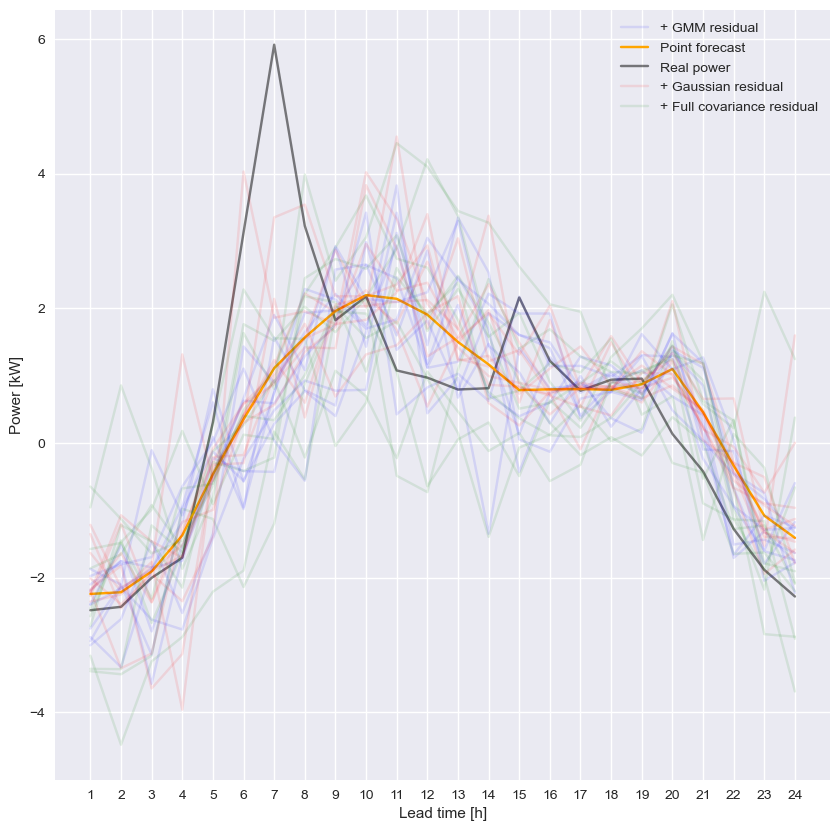

In [85]:
time_step = 1090
building = 0
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

temp = reals.loc[(reals['time_step'] > time_step) & (reals['time_step'] < (time_step+25))]
temp_scens_pv = scens_pv.loc[scens_pv['time_step'] == time_step]
temp_scens = scens.loc[scens['time_step'] == time_step]
temp_scens_covariance = scens_covariance.loc[scens_covariance['time_step'] == time_step]
temp_scens_point = scens_point.loc[scens_point['time_step'] == time_step]

# keep only building 1
temp = temp['building_{0}'.format(building)]
temp_scens_pv = temp_scens_pv.loc[temp_scens_pv['building'] == building].iloc[:, 3:].T
temp_scens = temp_scens.loc[temp_scens['building'] == building].iloc[:, 3:].T
temp_scens_covariance = temp_scens_covariance.loc[temp_scens_covariance['building'] == building].iloc[:, 3:].T
temp_scens_point = temp_scens_point.loc[temp_scens_point['building'] == building].iloc[:, 3:].T



# make index same as in scens_pv.iloc[:, 3:].T
temp.index = scens_pv.iloc[:, 3:].T.index
ax.plot(temp, color='black', alpha=0.5, label='Real power')
ax.plot(temp_scens_point, color='orange', alpha=1, label='Point forecast')
ax.plot(temp_scens_pv, color='blue', alpha=0.1, label='+ GMM residual')
ax.plot(temp_scens, color='red', alpha=0.1, label='+ Gaussian residual')
ax.plot(temp_scens_covariance, color='green', alpha=0.1, label='+ Full covariance residual')
# legend all blues lines are from point and variance and all red lines are from recurrent quantile
# from x axis labels remove first and last character
ax.set_xticklabels([x[1:-1] for x in temp_scens_pv.index])
# add axis labels
ax.set_xlabel('Lead time [h]')
ax.set_ylabel('Power [kW]')
# Create a legend with unique labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
handles_dict = {label: [] for label in unique_labels}
for handle, label in zip(handles, labels):
    handles_dict[label].append(handle)
unique_handles = [handles_dict[label][0] for label in unique_labels]
ax.legend(unique_handles, unique_labels)

# keep the same y limits
ax.set_ylim(-5.001095838650162, 6.434569643110328)
plt.show()